```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. 

```

# Supervised Embedded Feature Selection Methods
[SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) is a meta-transformer that can be used along with any estimator that has a `coef_` or `feature_importances_` attribute after fitting. The features are considered unimportant and removed, if the corresponding `coef_` or `feature_importances_` values are below the provided threshold parameter. Apart from specifying the threshold numerically, there are built-in heuristics for finding a threshold using a `string argument`. Available heuristics are `mean`, `median` and float multiples of these like `0.1*mean`. In combination with the threshold criteria, one can use the `max_features` parameter to set a limit on the number of features to select.

In [1]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [2]:
from datasets import (
    get_dataset
)

from feature_selection import (
    select_features
)

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [4]:
import sklearn
print(sklearn.__version__)

0.23.2


## Feature selection using SelectFromModel and LassoCV
[Use SelectFromModel meta-transformer along with Lasso to select the best couple of features from the diabetes dataset](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py).

Since the `L1 norm` promotes sparsity of features we might be interested in selecting only a subset of the most interesting features from the dataset. This example shows how to select two the most interesting features from the diabetes dataset.

Diabetes dataset consists of 10 variables (features) collected from 442 diabetes patients. This example shows how to use SelectFromModel and LassoCv to find the best two features predicting disease progression after one year from the baseline.

In [5]:
from sklearn.datasets import load_diabetes
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

In [6]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

feature_names = diabetes.feature_names
print(feature_names)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


To decide on the importance of the features we are going to use `LassoCV` estimator. The features with the highest absolute `coef_` value are considered the most important.

In [10]:
clf = LassoCV().fit(X, y)
importance = np.abs(clf.coef_)
print(importance)

[  6.49684455 235.99640534 521.73854261 321.06689245 569.4426838
 302.45627915   0.         143.6995665  669.92633112  66.83430445]


Now we want to select the two features which are the most important. `SelectFromModel()` allows for setting the threshold. Only the features with the `coef_` higher than the threshold will remain. Here, we want to set the threshold slightly above the third highest `coef_` calculated by `LassoCV()` from our data.

In [11]:
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01

idx_features = (-importance).argsort()[:2]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

Selected features: ['s5' 's1']


In [18]:
sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X, y)
X_transform = sfm.transform(X)

n_features = sfm.transform(X).shape[1]
n_features

2

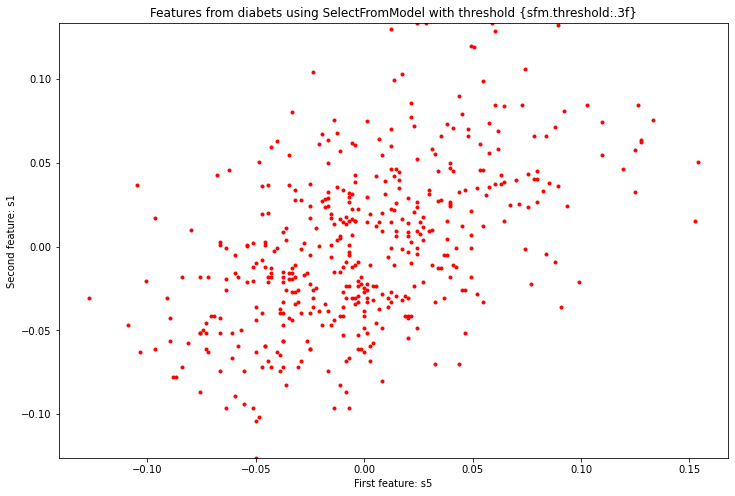

In [20]:
# Plot the selected two features from the data
fig, ax = plt.subplots(figsize=(12, 8))
plt.title(
    "Features from diabets using SelectFromModel with "
    "threshold {sfm.threshold:.3f}")
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("First feature: {}".format(name_features[0]))
plt.ylabel("Second feature: {}".format(name_features[1]))
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

## Feature importances with forests of trees
[This example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py) shows the use of forests of trees to evaluate the importance of features on an artificial classification task. The red bars are the impurity-based feature importances of the forest, along with their inter-trees variability.

As expected, the plot suggests that 3 features are informative, while the remaining are not.

**Warning:** impurity-based feature importances can be misleading for high cardinality features (many unique values). See [sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) as an alternative.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

In [22]:
# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

In [23]:
# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [24]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


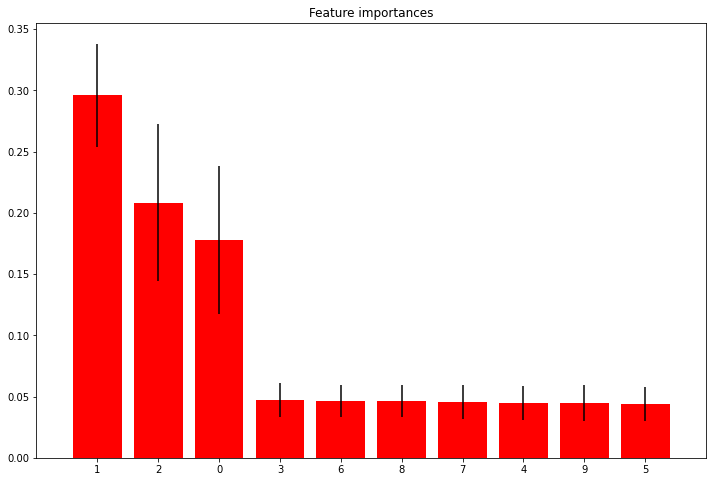

In [25]:
# Plot the impurity-based feature importances of the forest
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()